In [1]:
import pandas as pd
import sweetviz as sv
import numpy as np
import helper
from scipy import stats

# Introduction

This project involves analyzing the Home Credit Default Risk dataset from Kaggle. The primary goal is to build a predictive model with a ROC-AUC score of at least 0.77.The reason why we chose the ROC-AUC score is that it was the metric used to evaluate the best model in the Kaggle competition. The model aims to provide accurate probabilities for credit default, which is crucial for making informed lending decisions.

The initial objective is to develop a model that meets or exceeds a ROC-AUC score of 0.77. After achieving this target, the model will undergo hyperparameter tuning to optimize its performance. We will use Brier Score and model calibration techniques to ensure the model provides reliable probability estimates.

The dataset includes various features related to credit applications, such as application data, historical credit card balance data, information on previous installment payments, point of sale cash balance data, data on previous loan applications, and credit bureau data and balance information.

The methodology involves several steps. First, we will perform Exploratory Data Analysis (EDA) to understand the data distribution and identify any anomalies or patterns. Next, we will create new features that may improve the model's predictive power. We will then train various machine learning models and evaluate their performance using ROC-AUC. We will use techniques like Platt Scaling or Isotonic Regression for model calibration to ensure the model provides accurate probability estimates. Finally, we will evaluate the model using the Brier Score and other relevant metrics.

The tools and libraries used in this project include Python as the primary programming language, Pandas for data manipulation and analysis, Sweetviz for automated EDA and visualization, Scikit-learn for machine learning model training and evaluation, Matplotlib/Seaborn for data visualization, and NumPy for numerical computations.

By following this structured approach, the project aims to develop a robust predictive model that meets the target ROC-AUC score and provides reliable probability estimates for credit default risk.

# Load the DataFrames

In [6]:
installments_payments = pd.read_csv("installments_payments.csv")
credit_card = pd.read_csv("credit_card_balance.csv")
POS_CASH_balance = pd.read_csv("POS_CASH_balance.csv")
previous_application = pd.read_csv("previous_application.csv")
bureau = pd.read_csv("bureau.csv")
bureau_balance = pd.read_csv("bureau_balance.csv")
application_train = pd.read_csv("application_train.csv")
HomeCredit_columns_description = pd.read_csv(
    "HomeCredit_columns_description.csv", encoding="latin-1"
)

# Sweetviz analysis

First of all we will do a Sweetviz analysis on each DataFrame to get a general idea of the data. All the analysis reports will be saved to an HTML file.

In [ ]:
report_credit_card = sv.analyze(credit_card)
report_POS_CASH_balance = sv.analyze(POS_CASH_balance)
report_previous_application = sv.analyze(previous_application)
report_bureau = sv.analyze(bureau)
report_application_train = sv.analyze(application_train)
report_installments_payments = sv.analyze(installments_payments)

report_credit_card.show_html('report_credit_card.html')
report_POS_CASH_balance.show_html('report_POS_CASH_balance.html')
report_previous_application.show_html('report_previous_application.html')
report_bureau.show_html('report_bureau.html')
report_application_train.show_html('report_application_train.html')
report_installments_payments.show_html('report_installments_payments.html')

Based on the Sweetviz analysis, we observed that many features have a majority of values as NaN or the same value. For the initial model, we will use only the features with more than 40% of values as non-NaN and where the most common value does not exceed 90% of the total values. The removed features will be stored for potential future use.

In [7]:
dataframes = {
    "installments_payments": installments_payments,
    "credit_card_balance": credit_card,
    "POS_CASH_balance": POS_CASH_balance,
    "previous_application": previous_application,
    "bureau": bureau,
    "application_train": application_train,
}

cleaned_dataframes, dropped_columns_dict, total_columns_dict = (
    helper.clean_all_dataframes(dataframes)
)

(
    installments_payments,
    credit_card,
    POS_CASH_balance,
    previous_application,
    bureau,
    application_train,
) = [cleaned_dataframes[name] for name in cleaned_dataframes]

Cleaned DataFrame: installments_payments
Dropped Columns: []
Total Columns: 8
Columns Dropped: 0
Cleaned DataFrame: credit_card_balance
Dropped Columns: ['AMT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT', 'NAME_CONTRACT_STATUS', 'SK_DPD', 'SK_DPD_DEF']
Total Columns: 23
Columns Dropped: 7
Cleaned DataFrame: POS_CASH_balance
Dropped Columns: ['NAME_CONTRACT_STATUS', 'SK_DPD', 'SK_DPD_DEF']
Total Columns: 8
Columns Dropped: 3
Cleaned DataFrame: previous_application
Dropped Columns: ['FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'DAYS_FIRST_DRAWING']
Total Columns: 37
Columns Dropped: 5
Cleaned DataFrame: bureau
Dropped Columns: ['CREDIT_CURRENCY', 'CREDIT_DAY_OVERDUE', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'AMT_ANNUITY']
Total Columns: 17
Columns Dropped: 7
Cleaned DataFrame: application_train
Dropped 

Let`s check how many SK_ID_CURR are common in each data frame with application_train. We will also check how many SK_ID_BUREAU are common in bureau and bureau_balance.

In [8]:
datasets = {
    "installments_payments": installments_payments,
    "credit_card": credit_card,
    "POS_CASH_balance": POS_CASH_balance,
    "previous_application": previous_application,
    "bureau": bureau,
}

percentages_sk_id_curr, percentage_sk_id_bureau = (
    helper.calculate_common_id_percentages(
        application_train, datasets, bureau, bureau_balance
    )
)

for name, percentage in percentages_sk_id_curr.items():
    print(
        f"{percentage:.2f}% of SK_ID_CURR in application_train have an entry in {name}"
    )

print(
    f"{percentage_sk_id_bureau:.2f}% of SK_ID_BUREAU in bureau have an entry in bureau_balance"
)

94.84% of SK_ID_CURR in application_train have an entry in installments_payments
28.26% of SK_ID_CURR in application_train have an entry in credit_card
94.12% of SK_ID_CURR in application_train have an entry in POS_CASH_balance
94.65% of SK_ID_CURR in application_train have an entry in previous_application
85.69% of SK_ID_CURR in application_train have an entry in bureau
45.11% of SK_ID_BUREAU in bureau have an entry in bureau_balance


We won't use credit_card( just 28.26% of  sk_id_curr are the same). We will also not use  bureau_balance or bureau data frames. According to a former Home Credit employee, this dataset is not very useful for predicting the target variable because many people have low exposure to banking, making the data insufficient for credit-scoring loan applications. In these regions, people use a lot of cash and only a few banking services. So, we will focus on installments_payments, POS_CASH_balance, previous_application, and application_train data frames. If our model does not perform well, we can consider using these data frames in the future.

## application_train.csv

- This is the main table, where our target variable is present(TARGET).
- Static data for all applications. One row represents one loan in our data sample.

From the Sweetviz analysis, we observe that our target variable is 'TARGET', with 8% of the values being 1. The amount of credit taken by people ranges from 45,000 to 4,050,000. Information about the currency was not provided, so it might be a mix of different currencies.

In [9]:
application_train.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,TOTALAREA_MODE,WALLSMATERIAL_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0.0149,"Stone, brick",2.0,2.0,2.0,-1134.0,1,0.0,0.0,1.0
1,100003,0,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0.0714,Block,1.0,0.0,1.0,-828.0,1,0.0,0.0,0.0
2,100004,0,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,0.0,0.0,0.0,-815.0,0,0.0,0.0,0.0
3,100006,0,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,NaN,NaN,2.0,0.0,2.0,-617.0,1,NaN,NaN,NaN
4,100007,0,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,0.0,0.0,0.0,-1106.0,0,0.0,0.0,0.0


We will convert the negative values to positive for the following columns: 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', and 'DAYS_LAST_PHONE_CHANGE'. We will also divide 'DAYS_BIRTH' by 365.25 to convert it to years and round it to two decimal places.

In [10]:
application_train = (
    application_train.select_dtypes(include=[np.number])
    .abs()
    .join(application_train.select_dtypes(exclude=[np.number]))
)

application_train["DAYS_BIRTH"] = (application_train["DAYS_BIRTH"] / 365.25).round(2)
application_train.rename(columns={"DAYS_BIRTH": "AGE"}, inplace=True)

application_train.loc[application_train["DAYS_EMPLOYED"] == 365243, "DAYS_EMPLOYED"] = np.nan

application_train.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,AGE,DAYS_EMPLOYED,...,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,WALLSMATERIAL_MODE
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,25.90,637.0,...,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,"Stone, brick"
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,45.90,1188.0,...,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School,Block
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,52.15,225.0,...,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government,NaN
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,52.03,3039.0,...,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,NaN
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,54.57,3038.0,...,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion,NaN


In [11]:
application_train.shape

(307511, 72)

In [12]:
duplicate_rows = application_train.duplicated().sum()
print(f"Number of duplicate rows in application_train: {duplicate_rows}")

Number of duplicate rows in application_train: 0



We will now create new features. We are most interested in ratios and differences between income and expenses or credit. We will also create new features using the external data sources 'EXT_SOURCE_1', 'EXT_SOURCE_2', and 'EXT_SOURCE_3'.These features probably stand for external income sources. We will create new features using these columns.

In [13]:
application_train["CREDIT_INCOME_RATIO"] = (
    application_train["AMT_CREDIT"] / application_train["AMT_INCOME_TOTAL"]
)
application_train["CREDIT_ANNUITY_RATIO"] = (
    application_train["AMT_CREDIT"] / application_train["AMT_ANNUITY"]
)
application_train["ANNUITY_INCOME_RATIO"] = (
    application_train["AMT_ANNUITY"] / application_train["AMT_INCOME_TOTAL"]
)
application_train["INCOME_ANNUITY_DIFF"] = (
    application_train["AMT_INCOME_TOTAL"] - application_train["AMT_ANNUITY"]
)
application_train["CREDIT_GOODS_RATIO"] = (
    application_train["AMT_CREDIT"] / application_train["AMT_GOODS_PRICE"]
)
application_train["CREDIT_GOODS_DIFF"] = (
    application_train["AMT_CREDIT"] - application_train["AMT_GOODS_PRICE"]
)
application_train["GOODS_INCOME_RATIO"] = (
    application_train["AMT_GOODS_PRICE"] / application_train["AMT_INCOME_TOTAL"]
)
application_train["INCOME_EXT1_RATIO"] = (
    application_train["AMT_INCOME_TOTAL"] / application_train["EXT_SOURCE_1"]
)
application_train["CREDIT_EXT1_RATIO"] = (
    application_train["AMT_CREDIT"] / application_train["EXT_SOURCE_1"]
)
application_train["INCOME_EXT2_RATIO"] = (
    application_train["AMT_INCOME_TOTAL"] / application_train["EXT_SOURCE_2"]
)
application_train["CREDIT_EXT2_RATIO"] = (
    application_train["AMT_CREDIT"] / application_train["EXT_SOURCE_2"]
)
application_train["INCOME_EXT3_RATIO"] = (
    application_train["AMT_INCOME_TOTAL"] / application_train["EXT_SOURCE_3"]
)
application_train["CREDIT_EXT3_RATIO"] = (
    application_train["AMT_CREDIT"] / application_train["EXT_SOURCE_3"]
)
application_train["EXT_SOURCE_SUM"] = application_train[
    ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]
].sum(axis=1)
application_train["INCOME_EXTSUM_RATIO"] = (
    application_train["AMT_INCOME_TOTAL"] / application_train["EXT_SOURCE_SUM"]
)
application_train["CREDIT_EXTSUM_RATIO"] = (
    application_train["AMT_CREDIT"] / application_train["EXT_SOURCE_SUM"]
)
application_train["EXT_SOURCE_MEAN"] = application_train[
    ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]
].mean(axis=1)

- Correlation

We will use phi_k correlation to find the correlation between the categorical columns and the target variable. We will also use the Spearman correlation for the numerical columns and the target variable.

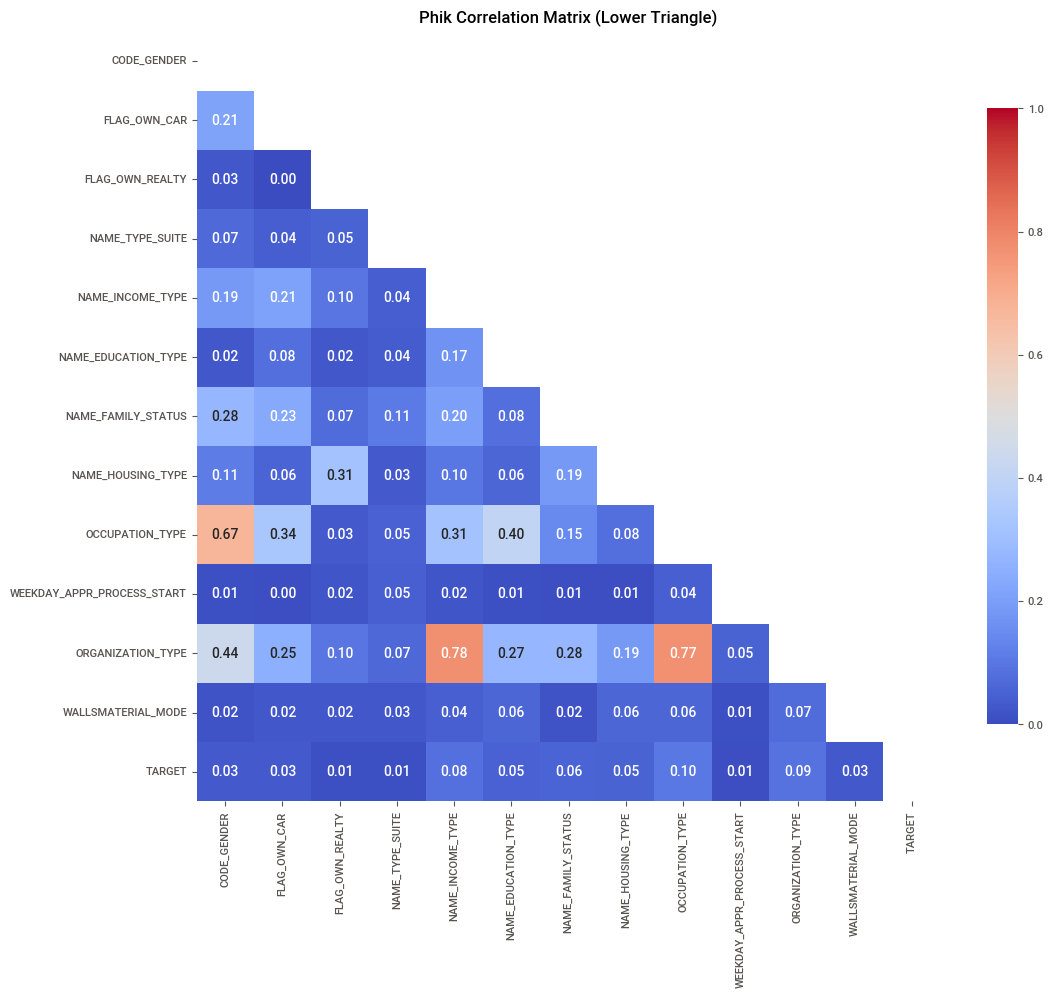

In [14]:
helper.plot_phik_correlation_matrix(application_train, "TARGET")

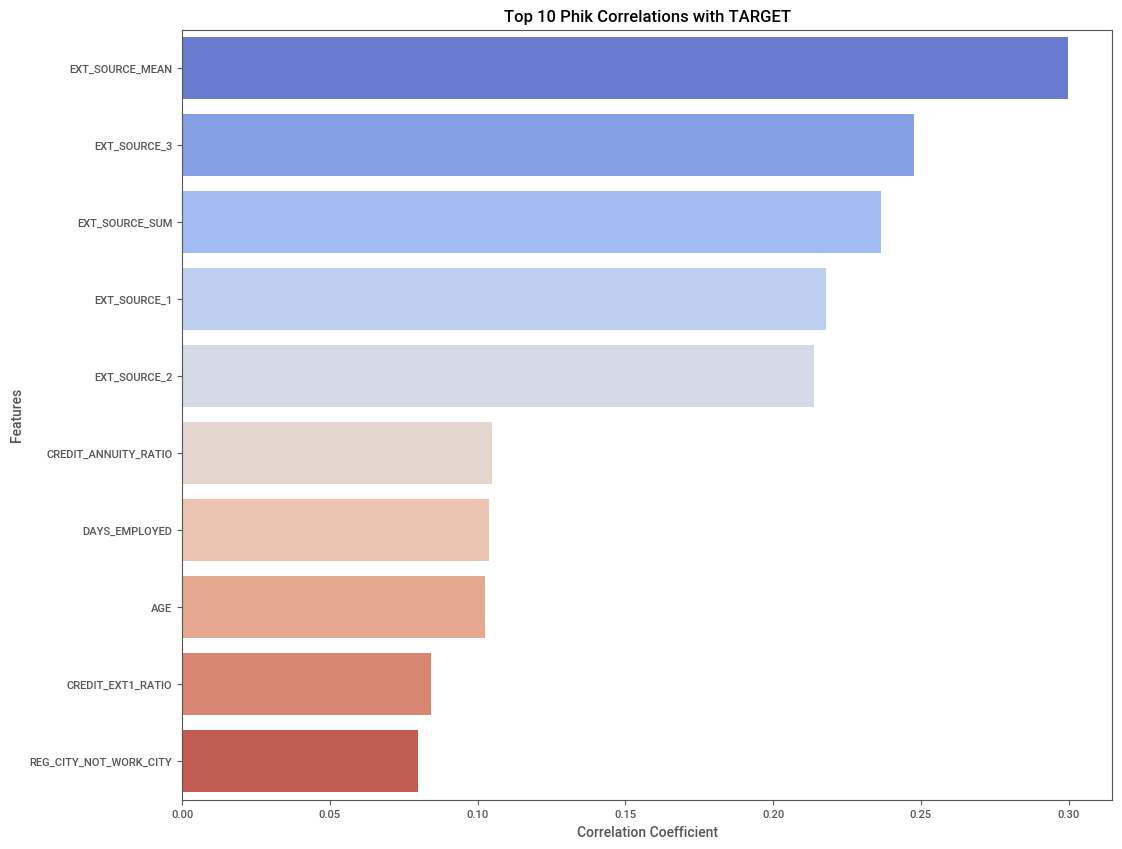

In [15]:
helper.plot_phik_correlation_with_target(application_train, "TARGET", "SK_ID_CURR", 10)

It is worth noting that the features correlated with the target variable, `EXT_SOURCE_1` and `EXT_SOURCE_3`, have 56% and 20% missing values, respectively.

## installments_payments.csv

- Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.

- There is a) one row for every payment that was made plus b) one row each for missed payment.

- One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

In [16]:
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


We will convert the negative values to positive

In [17]:
installments_payments = (
    installments_payments.select_dtypes(include=[np.number])
    .abs()
    .join(installments_payments.select_dtypes(exclude=[np.number]))
)

First we will filter the SK_ID_CURR that are in the application_train dataset

In [18]:
installments_payments = installments_payments[
    installments_payments["SK_ID_CURR"].isin(application_train["SK_ID_CURR"])
]

We will sort the DataFrame by 'SK_ID_CURR', 'SK_ID_PREV', and 'NUM_INSTALMENT_NUMBER' and calculate the cumulative sums for 'AMT_PAYMENT' and 'AMT_INSTALMENT'. We will then calculate the payment ratio and the number of days past due. These features will help us understand the payment behavior of the clients.

In [19]:
installments_payments.sort_values(
    by=["SK_ID_CURR", "SK_ID_PREV", "NUM_INSTALMENT_NUMBER"], inplace=True
)

installments_payments["cumulative_amt_payment"] = installments_payments.groupby(
    ["SK_ID_CURR", "SK_ID_PREV"]
)["AMT_PAYMENT"].cumsum()
installments_payments["cumulative_amt_instalment"] = installments_payments.groupby(
    ["SK_ID_CURR", "SK_ID_PREV"]
)["AMT_INSTALMENT"].cumsum()

installments_payments["payment_ratio"] = (
    installments_payments["cumulative_amt_payment"]
    / installments_payments["cumulative_amt_instalment"]
)

installments_payments["DAYS_PAST_DUE"] = (
    installments_payments["DAYS_ENTRY_PAYMENT"]
    - installments_payments["DAYS_INSTALMENT"]
)

In [20]:
HomeCredit_columns_description[
    HomeCredit_columns_description["Table"] == "installments_payments.csv"
]

,Unnamed: 0,Table,Row,Description,Special
211,214,installments_payments.csv,SK_ID_PREV,ID of previous credit in Home credit related t...,hashed
212,215,installments_payments.csv,SK_ID_CURR,ID of loan in our sample,hashed
213,216,installments_payments.csv,NUM_INSTALMENT_VERSION,Version of installment calendar (0 is for cred...,NaN
214,217,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,NaN
215,218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was su...,time only relative to the application
216,219,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...,time only relative to the application
217,220,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of ...,NaN
218,221,installments_payments.csv,AMT_PAYMENT,What the client actually paid on previous cred...,NaN


We will now create new features such as the min, max, and mean of the payment ratio and days past due. We will extract information from the total number of payments and days past due, focusing on the first five payments and total payments, as advised by a former Home Credit employee who mentioned that the first payments are more important than the last ones.

In [21]:
installments_payments = helper.feature_engineering_installments_payments(
    installments_payments
)

C:\Users\Kestutis\PycharmProjects\capstone_ml\helper.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_installments_payments.drop(columns=columns_to_drop, inplace=True)


In [22]:
installments_payments_target = installments_payments.merge(
    application_train[["SK_ID_CURR", "TARGET"]], on="SK_ID_CURR", how="left"
)

installments_payments_target.head()

,SK_ID_CURR,payment_ratio_min_all,payment_ratio_max_all,payment_ratio_mean_all,DAYS_PAST_DUE_min_all,DAYS_PAST_DUE_max_all,DAYS_PAST_DUE_mean_all,payment_ratio_min_first_five,payment_ratio_max_first_five,payment_ratio_mean_first_five,DAYS_PAST_DUE_min_first_five,DAYS_PAST_DUE_max_first_five,DAYS_PAST_DUE_mean_first_five,payment_ratio_last,DAYS_PAST_DUE_last,TARGET
0,100002,1.0,1.0,1.000000,12.0,31.0,20.421053,1.0,1.0,1.000000,22.0,27.0,23.800000,1.00000,24.0,1
1,100003,1.0,1.0,1.000000,1.0,14.0,7.160000,1.0,1.0,1.000000,3.0,14.0,8.066667,1.00000,14.0,0
2,100004,1.0,1.0,1.000000,3.0,11.0,7.666667,1.0,1.0,1.000000,3.0,11.0,7.666667,1.00000,3.0,0
3,100006,1.0,1.0,1.000000,1.0,77.0,19.375000,1.0,1.0,1.000000,4.0,77.0,27.000000,1.00000,13.0,0
4,100007,0.5,1.0,0.959827,-12.0,31.0,3.636364,0.5,1.0,0.944192,-8.0,30.0,2.884615,0.85749,-3.0,0


- Correlation

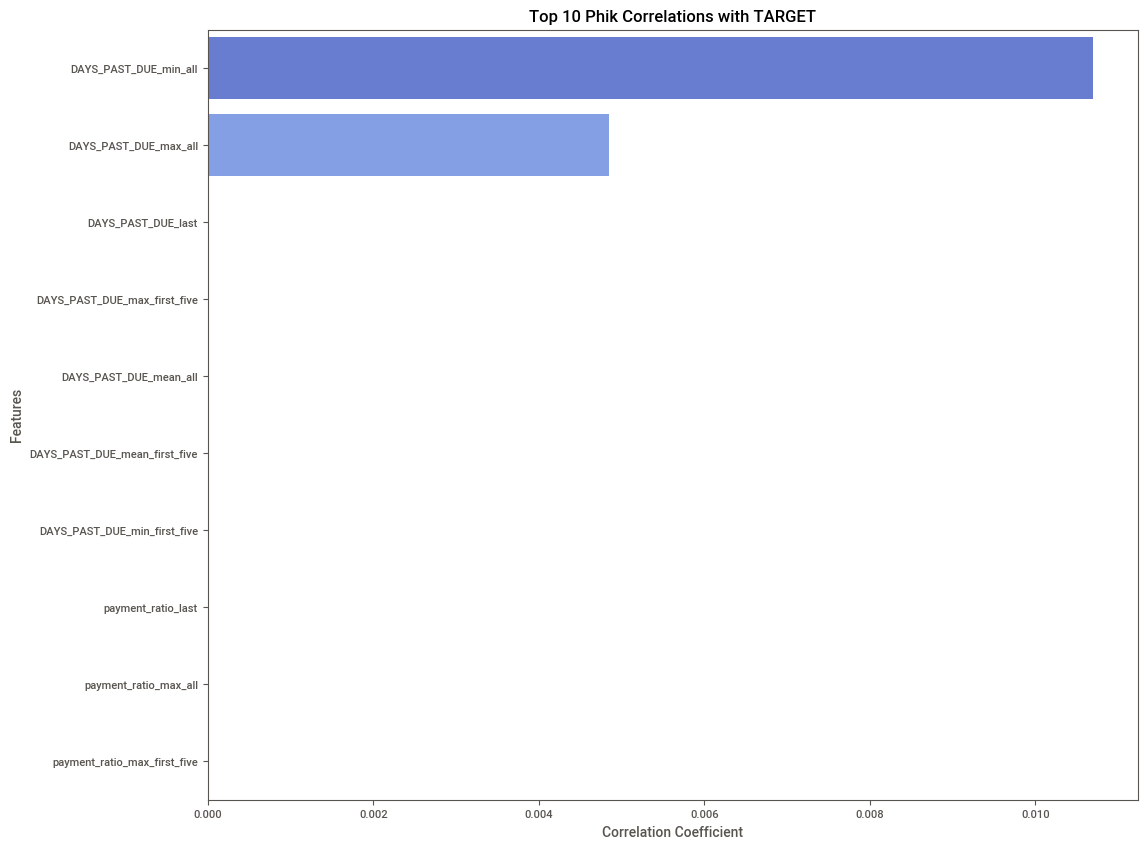

In [23]:
helper.plot_phik_correlation_with_target(
    installments_payments_target, "TARGET", "SK_ID_CURR", 10
)

## POS_CASH_balance.csv

- Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
- This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

In [24]:
POS_CASH_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE
0,1803195,182943,-31,48.0,45.0
1,1715348,367990,-33,36.0,35.0
2,1784872,397406,-32,12.0,9.0
3,1903291,269225,-35,48.0,42.0
4,2341044,334279,-35,36.0,35.0


We will convert the negative values to positive

In [25]:
POS_CASH_balance = (
    POS_CASH_balance.select_dtypes(include=[np.number])
    .abs()
    .join(POS_CASH_balance.select_dtypes(exclude=[np.number]))
)

First we will filter the SK_ID_CURR that are in the application_train dataset

In [26]:
POS_CASH_balance = POS_CASH_balance[
    POS_CASH_balance["SK_ID_CURR"].isin(application_train["SK_ID_CURR"])
]

In [27]:
HomeCredit_columns_description[
    HomeCredit_columns_description["Table"] == "POS_CASH_balance.csv"
]

,Unnamed: 0,Table,Row,Description,Special
142,145,POS_CASH_balance.csv,SK_ID_PREV,ID of previous credit in Home Credit related t...,NaN
143,146,POS_CASH_balance.csv,SK_ID_CURR,ID of loan in our sample,NaN
144,147,POS_CASH_balance.csv,MONTHS_BALANCE,Month of balance relative to application date ...,time only relative to the application
145,148,POS_CASH_balance.csv,CNT_INSTALMENT,Term of previous credit (can change over time),NaN
146,149,POS_CASH_balance.csv,CNT_INSTALMENT_FUTURE,Installments left to pay on the previous credit,NaN
147,150,POS_CASH_balance.csv,NAME_CONTRACT_STATUS,Contract status during the month,NaN
148,151,POS_CASH_balance.csv,SK_DPD,DPD (days past due) during the month of previo...,NaN
149,152,POS_CASH_balance.csv,SK_DPD_DEF,DPD during the month with tolerance (debts wit...,NaN


We will sort the DataFrame by 'SK_ID_CURR' and 'SK_ID_PREV' and calculate the min, max, mean, and last values of 'CNT_INSTALMENT' and 'CNT_INSTALMENT_FUTURE'. We will also calculate the last 'MONTHS_BALANCE' and the number of unique 'SK_ID_PREV' values.

In [28]:
POS_CASH_balance.sort_values(by=["SK_ID_CURR", "SK_ID_PREV"], inplace=True)

aggregated_POS_CASH_balance = (
    POS_CASH_balance.groupby("SK_ID_CURR")
    .agg(
        min_cnt_instalment=("CNT_INSTALMENT", "min"),
        max_cnt_instalment=("CNT_INSTALMENT", "max"),
        mean_cnt_instalment=("CNT_INSTALMENT", "mean"),
        last_cnt_instalment=("CNT_INSTALMENT", "last"),
        last_cnt_instalment_future=("CNT_INSTALMENT_FUTURE", "last"),
        last_month_balance=("MONTHS_BALANCE", "last"),
        unique_sk_id_prev_count=("SK_ID_PREV", "nunique"),
    )
    .reset_index()
)

aggregated_POS_CASH_balance.head()

,SK_ID_CURR,min_cnt_instalment,max_cnt_instalment,mean_cnt_instalment,last_cnt_instalment,last_cnt_instalment_future,last_month_balance,unique_sk_id_prev_count
0,100002,24.0,24.0,24.000000,24.0,20.0,15,1
1,100003,6.0,12.0,10.107143,6.0,6.0,28,3
2,100004,3.0,4.0,3.750000,4.0,3.0,26,1
3,100006,1.0,48.0,12.000000,5.0,0.0,13,3
4,100007,10.0,24.0,15.333333,12.0,1.0,47,5


- Correlation

In [29]:
POS_CASH_balance_target = aggregated_POS_CASH_balance.merge(
    application_train[["SK_ID_CURR", "TARGET"]], on="SK_ID_CURR", how="left"
)

In [30]:
POS_CASH_balance_target.head()

,SK_ID_CURR,min_cnt_instalment,max_cnt_instalment,mean_cnt_instalment,last_cnt_instalment,last_cnt_instalment_future,last_month_balance,unique_sk_id_prev_count,TARGET
0,100002,24.0,24.0,24.000000,24.0,20.0,15,1,1
1,100003,6.0,12.0,10.107143,6.0,6.0,28,3,0
2,100004,3.0,4.0,3.750000,4.0,3.0,26,1,0
3,100006,1.0,48.0,12.000000,5.0,0.0,13,3,0
4,100007,10.0,24.0,15.333333,12.0,1.0,47,5,0


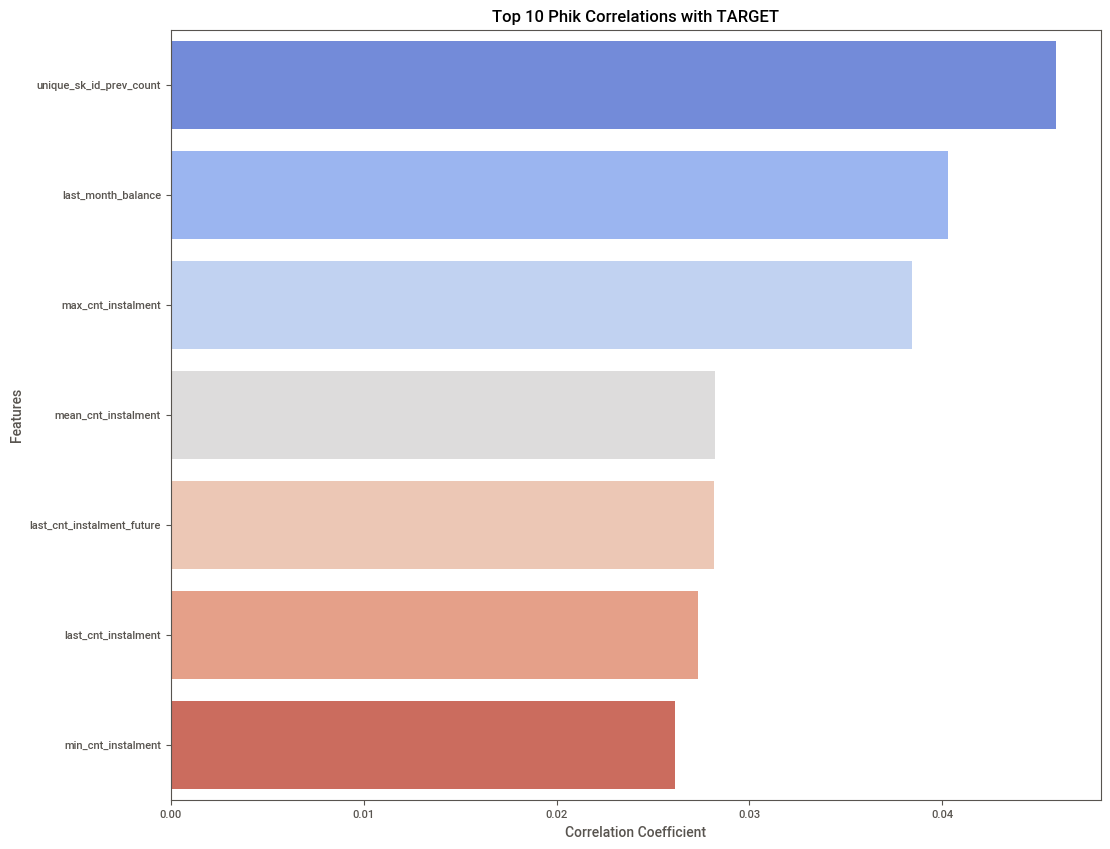

In [31]:
helper.plot_phik_correlation_with_target(
    POS_CASH_balance_target, "TARGET", "SK_ID_CURR", 10
)

## previous_application.csv

- Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
- There is a) one row for every payment that was made plus b) one row each for missed payment.
- One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

In [32]:
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,35,Connectivity,12.0,middle,POS mobile with interest,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,-1,XNA,36.0,low_action,Cash X-Sell: low,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,-1,XNA,12.0,high,Cash X-Sell: high,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,-1,XNA,12.0,middle,Cash X-Sell: middle,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN


In [33]:
previous_application = (
    previous_application.select_dtypes(include=[np.number])
    .abs()
    .join(previous_application.select_dtypes(exclude=[np.number]))
)

Relative to application date of current application when was the first due supposed to be of the previous application

In [34]:
previous_application = previous_application[
    previous_application["SK_ID_CURR"].isin(application_train["SK_ID_CURR"])
]

There are values of 365243 in the `DAYS_` columns, which represent approximately 1000 years. These values are incorrect, so we will replace them with `NaN`.

In [35]:
days_columns = [col for col in application_train.columns if col.startswith("DAYS_")]

previous_application[days_columns] = application_train[days_columns].replace(
    365243.0, np.nan
)

We will create new features such as the difference between the 'AMT_APPLICATION' and 'AMT_CREDIT' and the percentage of the 'AMT_DECLINED' relative to the 'AMT_APPLICATION'.

In [36]:
previous_application["AMT_DECLINED"] = (
    previous_application["AMT_APPLICATION"] - previous_application["AMT_CREDIT"]
)

previous_application["AMT_DECLINED_PERCENTAGE"] = (
    previous_application["AMT_DECLINED"] / previous_application["AMT_APPLICATION"]
) * 100

Now we will create new features. We will calculate the mean, max, and min values for the numerical columns and the count of unique values for the categorical columns. We will also extract the last row values for both numerical and categorical columns.

In [37]:
merged_previous_application = helper.process_previous_application(previous_application)

- Correlation

In [38]:
merged_df = merged_previous_application.merge(
    application_train[["SK_ID_CURR", "TARGET"]], on="SK_ID_CURR", how="left"
)

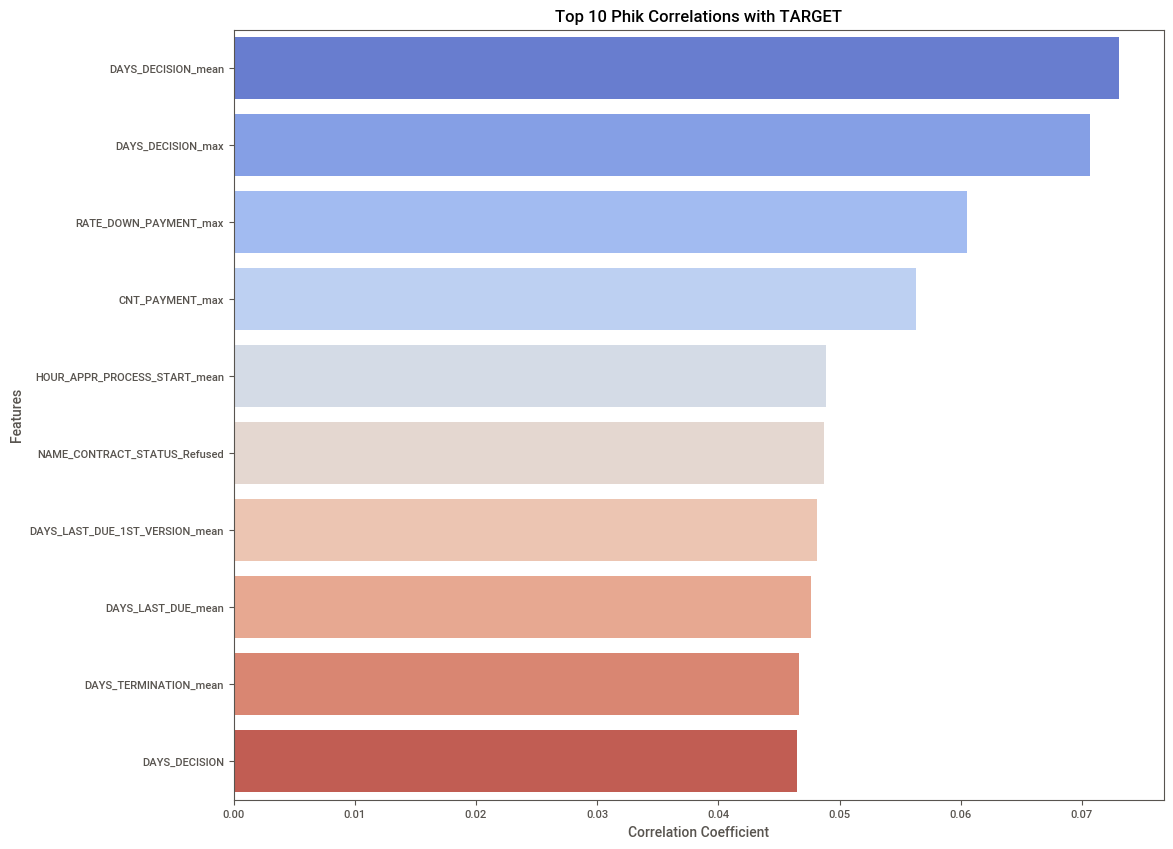

In [39]:
helper.plot_phik_correlation_with_target(merged_df, "TARGET", "SK_ID_CURR", 10)

In [40]:
application_train.set_index("SK_ID_CURR", inplace=True)
merged_previous_application.set_index("SK_ID_CURR", inplace=True)
installments_payments.set_index("SK_ID_CURR", inplace=True)
aggregated_POS_CASH_balance.set_index("SK_ID_CURR", inplace=True)

final_df = application_train.join(
    merged_previous_application, how="left", rsuffix="_prev_app"
)
final_df = final_df.join(installments_payments, how="left", rsuffix="_inst_pay")
final_df = final_df.join(aggregated_POS_CASH_balance, how="left", rsuffix="_pos_cash")

final_df.reset_index(inplace=True)

final_df.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,AGE,DAYS_EMPLOYED,...,DAYS_PAST_DUE_mean_first_five,payment_ratio_last,DAYS_PAST_DUE_last,min_cnt_instalment,max_cnt_instalment,mean_cnt_instalment,last_cnt_instalment,last_cnt_instalment_future,last_month_balance,unique_sk_id_prev_count
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,25.90,637.0,...,23.800000,1.00000,24.0,24.0,24.0,24.000000,24.0,20.0,15.0,1.0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,45.90,1188.0,...,8.066667,1.00000,14.0,6.0,12.0,10.107143,6.0,6.0,28.0,3.0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,52.15,225.0,...,7.666667,1.00000,3.0,3.0,4.0,3.750000,4.0,3.0,26.0,1.0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,52.03,3039.0,...,27.000000,1.00000,13.0,1.0,48.0,12.000000,5.0,0.0,13.0,3.0
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,54.57,3038.0,...,2.884615,0.85749,-3.0,10.0,24.0,15.333333,12.0,1.0,47.0,5.0


We will do a final cleaning of features with more than 40% missing values and where the most common value exceeds 90% of the total values. We will also replace infinite values with NaN.

In [41]:
final_df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [42]:
dataframes = {"final_df": final_df}

cleaned_dataframes, dropped_columns_dict, total_columns_dict = (
    helper.clean_all_dataframes(dataframes)
)

final_df = cleaned_dataframes["final_df"]

Cleaned DataFrame: final_df
Dropped Columns: ['NAME_CONTRACT_TYPE_XNA', 'NAME_CASH_LOAN_PURPOSE_Building a house or an annex', 'NAME_CASH_LOAN_PURPOSE_Business development', 'NAME_CASH_LOAN_PURPOSE_Buying a garage', 'NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land', 'NAME_CASH_LOAN_PURPOSE_Buying a home', 'NAME_CASH_LOAN_PURPOSE_Buying a new car', 'NAME_CASH_LOAN_PURPOSE_Buying a used car', 'NAME_CASH_LOAN_PURPOSE_Car repairs', 'NAME_CASH_LOAN_PURPOSE_Education', 'NAME_CASH_LOAN_PURPOSE_Everyday expenses', 'NAME_CASH_LOAN_PURPOSE_Furniture', 'NAME_CASH_LOAN_PURPOSE_Gasification / water supply', 'NAME_CASH_LOAN_PURPOSE_Hobby', 'NAME_CASH_LOAN_PURPOSE_Journey', 'NAME_CASH_LOAN_PURPOSE_Medicine', 'NAME_CASH_LOAN_PURPOSE_Money for a third person', 'NAME_CASH_LOAN_PURPOSE_Other', 'NAME_CASH_LOAN_PURPOSE_Payments on other loans', 'NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment', 'NAME_CASH_LOAN_PURPOSE_Refusal to name the goal', 'NAME_CASH_LOAN_PURPOSE_Repairs', 'NAME_CASH_LOAN_

In [43]:
final_df = final_df.drop(columns=['CODE_GENDER'])

In [44]:
final_df.shape

(307511, 269)

Our final data frame has 269 columns and 307511 rows.

Saving the final data frame to a parquet file.

In [ ]:
final_df.to_parquet("final_df.parquet", index=False)

# Hypothesis Testing

H0 (Null Hypothesis): There is no difference in the amount of credit between clients with TARGET=0 and TARGET=1.
H1 (Alternative Hypothesis): There is a difference in the amount of credit between clients with TARGET=0 and TARGET=1.

We will perform a two-sample T-Test to compare the means of the 'AMT_CREDIT' between clients with TARGET=0 and TARGET=1.

In [3]:
group1 = application_train[application_train['TARGET'] == 0]['AMT_CREDIT']
group2 = application_train[application_train['TARGET'] == 1]['AMT_CREDIT']

mean_group1 = group1.mean()
mean_group2 = group2.mean()

t_stat, p_value = stats.ttest_ind(group1, group2)

print(f"Mean of Group 1 (TARGET=0): {mean_group1}")
print(f"Mean of Group 2 (TARGET=1): {mean_group2}")
print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")

Mean of Group 1 (TARGET=0): 602648.2820019386
Mean of Group 2 (TARGET=1): 557778.527673716
T-Statistic: 16.848601925306788
P-Value: 1.1474602724788812e-63


P < 0.05, so we reject the null hypothesis. There is a significant difference in the amount of credit between clients with TARGET=0 and TARGET=1.